In [36]:
import sys
import os
import torch
import numpy as np
import torchvision
import cv2
import matplotlib.pyplot as plt
import WDNet

def inspect_imgs(test_img_path,max_cols, size=(20,20)):
    test_img = torchvision.io.read_image(test_img_path)
    test_img = test_img.float() / 255
    test_img = test_img.unsqueeze(0)
    test_img = test_img.to(device)

    rows = 1
    cols = len(dirs)
    #max_cols = 3
    if cols>max_cols:
        rows = len(dirs) // max_cols + 1
        cols = max_cols

    plt.rcParams["figure.figsize"] = size
    plt.subplot(rows, cols, 1)
    plt.gca().set_title('test image')
    plt.imshow(test_img.squeeze(0).cpu().permute(1,2,0))

    i=2
    for e in dirs:
        with torch.no_grad():  
            G_path = os.path.join(basic_path,'YandexDisk\ML_models\model_WDNet',e,'WDNet_G.pkl')
            G = WDNet.generator(3,3)
            G.to(device)
            G.load_state_dict(torch.load(G_path))
            G.eval()
            restored_img = G(test_img)

        plt.subplot(rows, cols, i)
        if len(e) == 0: e='latest'
        plt.gca().set_title(e)
        plt.imshow(restored_img[0].squeeze(0).cpu().permute(1,2,0).detach().numpy())
        i+=1

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
basic_path = '../../' # local drive
device='cuda'
#device='cpu'

dirs = os.listdir(os.path.join(basic_path,'YandexDisk\ML_models\model_WDNet'))
print(dirs)

['2023-10-30_colab', '2023-11-01_ds', '2024-03-24_local', '2024-03-27_local', '2024-04-13', '2024-04-16_myds-1', '2024-04-16_myds-3', '2024-04-16_mydsv2-1', '2024-04-16_mydsv2-2', 'pretrained_src']


In [4]:
torch.cuda.empty_cache()
args ={}
args['epoch'] = 1
args['batch_size'] = 5 # 12 for 16Gb
args['save_dir'] = os.path.join(basic_path,'YandexDisk\ML_models\model_WDNet','2024-04-16_mydsv2-2')
args['result_dir'] = ''
args['dataset'] = basic_path+'tmp/new_dataset/CLWD_ext'
args['log_dir'] = basic_path
args['gpu_mode'] = True if device=='cuda' else False
args['input_size'] = 28 # не знаю что это
args['dataloader_workers'] = 0 # 0 if windows
args['gan_type'] = 'CGAN'
args['lrG'] = 0.0002
args['lrD'] = 0.0002
args['beta1'] = 0.5
args['beta2'] = 0.999

In [5]:
for dir in dirs[8:]:
    print(f'=== {dir} ===')
    args['save_dir'] = os.path.join(basic_path,'YandexDisk\ML_models\model_WDNet',dir)
    wdnet = WDNet.WDNet(args)
    wdnet.test()

=== 2024-04-16_mydsv2-2 ===
Model loaded from ../../YandexDisk\ML_models\model_WDNet\2024-04-16_mydsv2-2
Results:    mask_BCE 28.1053    mask_BCE 28.1053   mask_MSE 0.2811   mask_SSIM 0.4455     img_BCE 0.4921   img_MSE 0.0007   img_L1 0.0129   img_SSIM 0.9479
Test data saved to ../../YandexDisk\ML_models\model_WDNet\2024-04-16_mydsv2-2
=== pretrained_src ===
Model loaded from ../../YandexDisk\ML_models\model_WDNet\pretrained_src
Results:    mask_BCE 10.0582    mask_BCE 10.0582   mask_MSE 0.1006   mask_SSIM 0.8063     img_BCE 0.4951   img_MSE 0.0011   img_L1 0.0142   img_SSIM 0.9445
Test data saved to ../../YandexDisk\ML_models\model_WDNet\pretrained_src


In [27]:
import pickle
import pandas as pd
to_pd = []
#print(f"{'Model':25s} mask_BCE    mask_MSE    mask_SSIM    img_BCE    img_MSE    img_L1    img_SSIM")
#print(f"--------------------------------------------------------------------------------------------------------")
for dir in dirs:
    path = os.path.join(basic_path,'YandexDisk\ML_models\model_WDNet',dir)
    with open(os.path.join(path,'WDNet_test.pkl'), 'rb') as f:
        test_data = pickle.load(f)
        last_iter = test_data[-1]
        last_iter['model_name'] = dir
        to_pd.append(last_iter)
        #print(f"{dir:25s} {last_iter['mask_BCE']:>7.4f}      {last_iter['mask_MSE']:>6.4f}       {last_iter['mask_SSIM']:>6.4f}      {last_iter['img_BCE']:>6.4f}     {last_iter['img_MSE']:>6.4f}    {last_iter['img_L1']:>6.4f}     {last_iter['img_SSIM']:>6.4f}")

df = pd.DataFrame(to_pd)
df = df[['model_name', 'mask_BCE', 'mask_MSE', 'mask_SSIM', 'img_BCE', 'img_MSE',
       'img_L1', 'img_SSIM']]
df.sort_values(by='img_SSIM')

model_name   mask_BCE  mask_MSE  mask_SSIM   img_BCE   img_MSE  \
9       pretrained_src  10.058224  0.100582   0.806260  0.495079  0.001115   
3     2024-03-27_local  11.529798  0.115298   0.782657  0.495102  0.001316   
7  2024-04-16_mydsv2-1  27.797134  0.277971   0.490328  0.492369  0.000701   
8  2024-04-16_mydsv2-2  28.105298  0.281053   0.445472  0.492137  0.000696   
5    2024-04-16_myds-1  28.426875  0.284269   0.487921  0.492303  0.000692   
6    2024-04-16_myds-3  18.891615  0.188916   0.573109  0.492035  0.000611   
4           2024-04-13   9.960017  0.099600   0.808396  0.493656  0.000759   
1        2023-11-01_ds   9.271742  0.092717   0.814524  0.493650  0.000764   
0     2023-10-30_colab   9.788072  0.097881   0.810781  0.493817  0.000817   
2     2024-03-24_local   9.486807  0.094868   0.811544  0.493762  0.000801   

     img_L1  img_SSIM  
9  0.014179  0.944458  
3  0.013292  0.947330  
7  0.012819  0.947801  
8  0.012914  0.947908  
5  0.012703  0.949367  
6  0.011769  0.955108  
4  0.011379  0.955431  
1  0.011367  0.955671  
0  0.011460  0.955851  
2  0.011367  0.956135

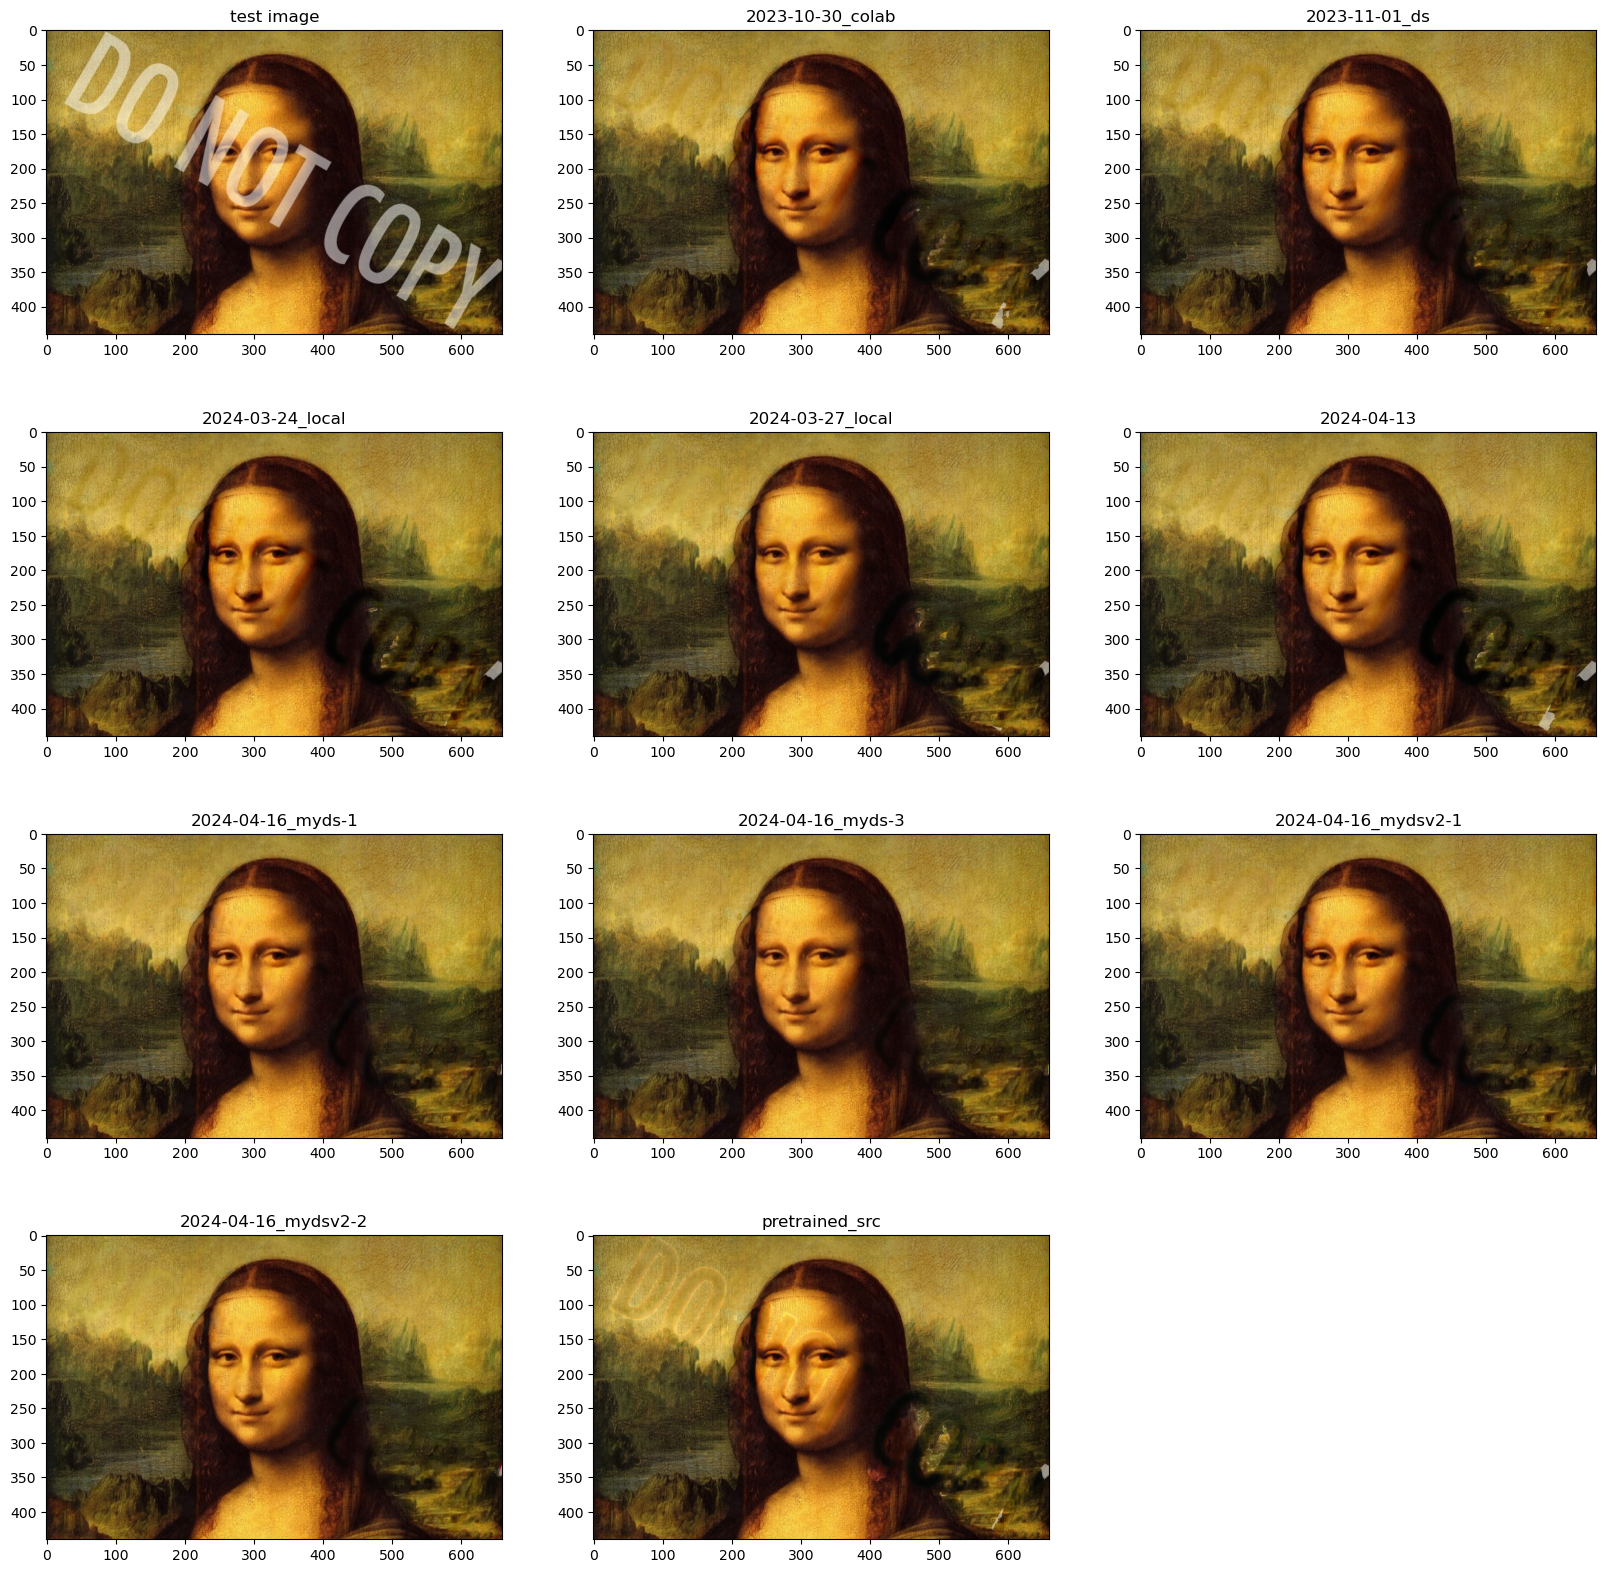

In [33]:
test_img_path = os.path.join('test_img','mona_lisa.jpg')
inspect_imgs(test_img_path,3)

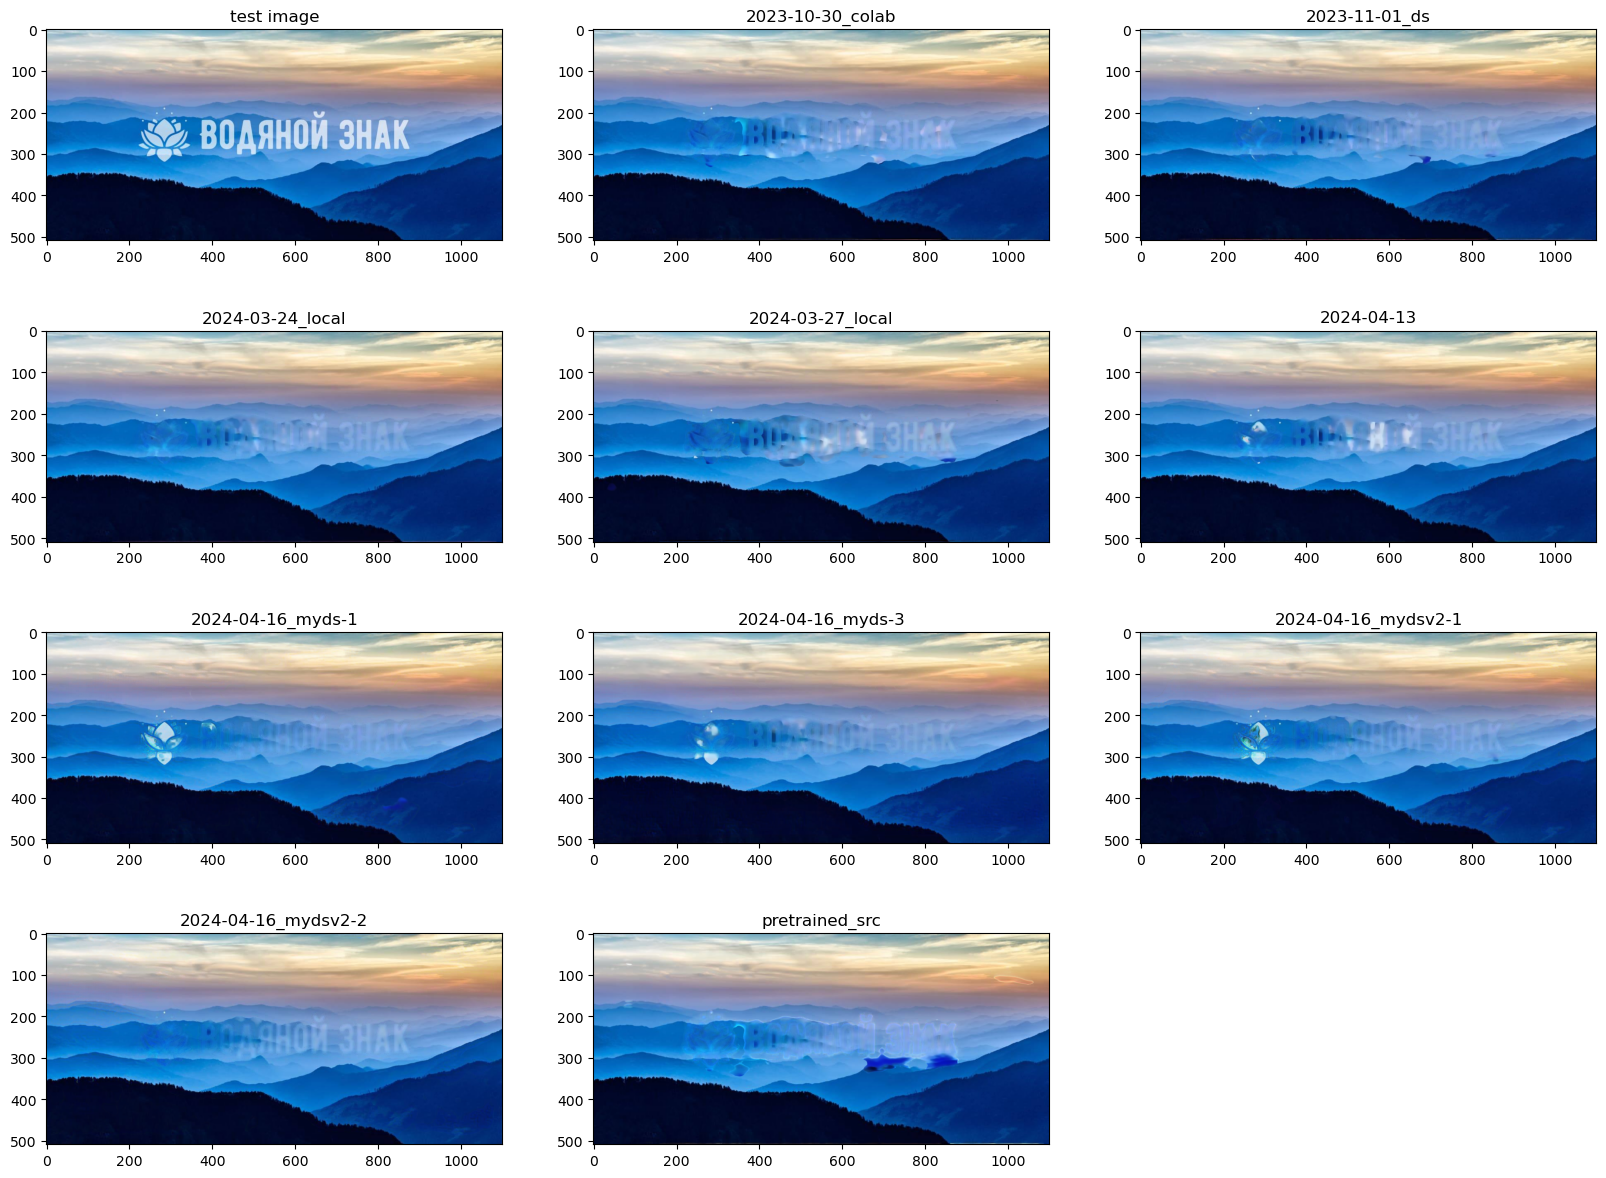

In [37]:
test_img_path = os.path.join('test_img','mountains.jpg')
inspect_imgs(test_img_path,3,(20,15))

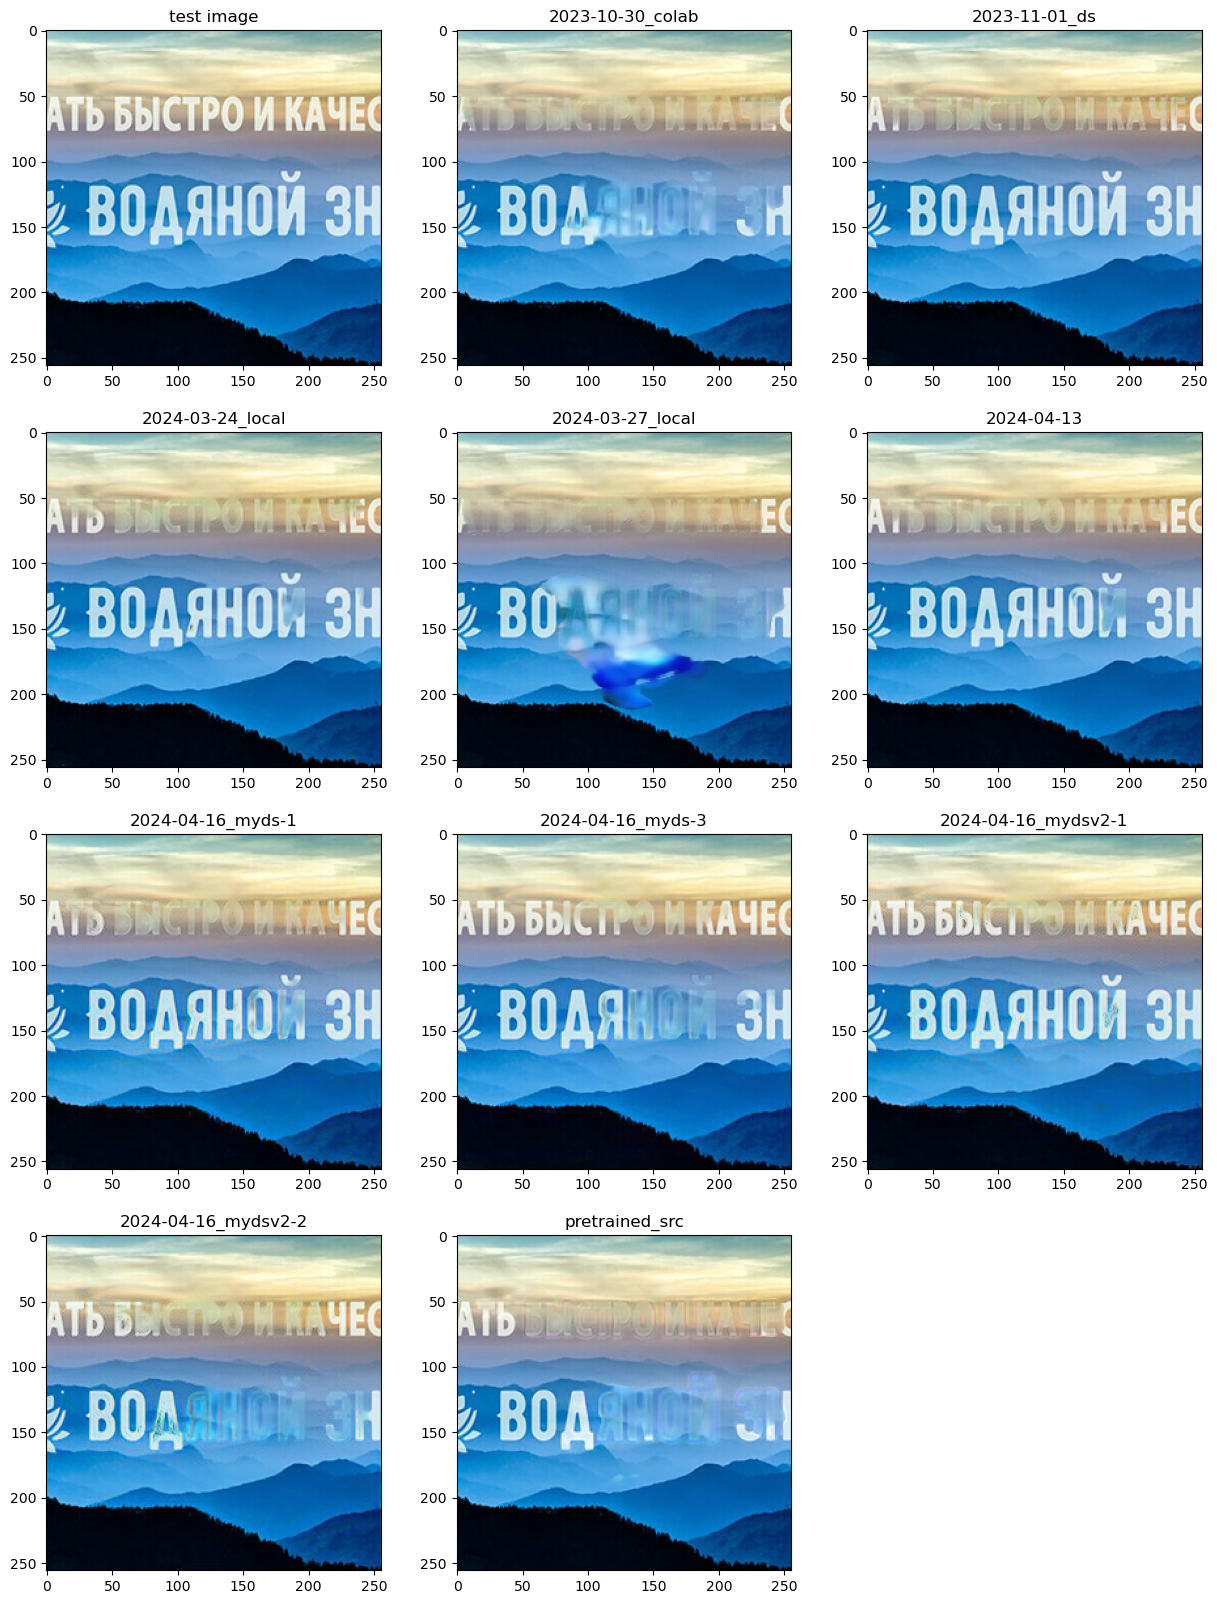

In [39]:
test_img_path = os.path.join('test_img','mountains_256.jpg')
inspect_imgs(test_img_path,3,(15,20))

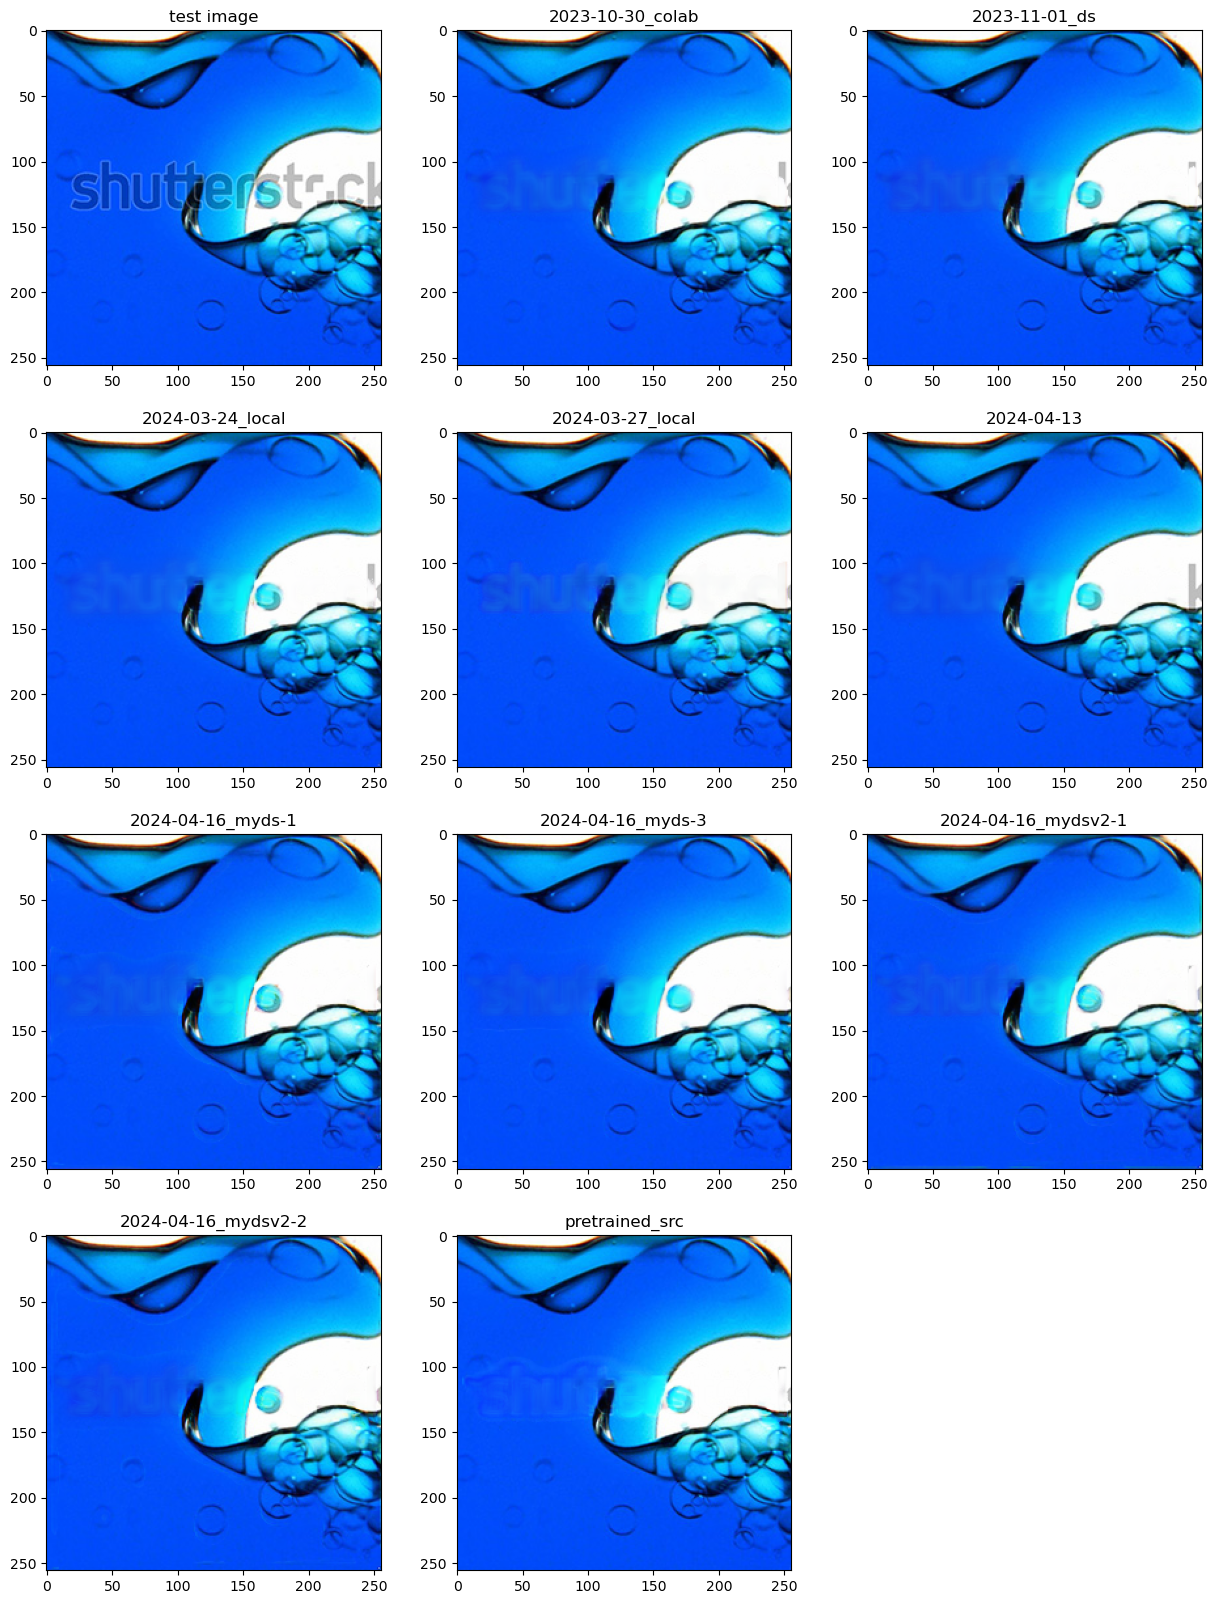

In [40]:
test_img_path = os.path.join('test_img','wave_256.jpg')
inspect_imgs(test_img_path,3,(15,20))